# DAEN 429 Homework 6
### Fletcher Newman | October 26th, 2025

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from d2l import torch as d2l
from collections import OrderedDict

In [2]:
# Import data
data = d2l.FashionMNIST(batch_size=128)
len(data.train), len(data.val)

# DataLoaders
train_loader = DataLoader(data.train, batch_size=64, shuffle=True)
val_loader = DataLoader(data.val, batch_size=64, shuffle=False)

# Defining the model

I will be implementing a LeNet CNN

In [3]:
# LeNet class
def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):  #@save
    """
    The LeNet-5 model
    Uses sigmoid activation function
    Kernel Size and pool size can be adjusted 
    """
    def __init__(self, kernel_1_size=5, pool_size=2, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()

        # Add feature extractor to do convolutional part
        self.feature_extractor = nn.Sequential(
            # Layer 1 -> 5x5 conv with 6 channels, pad 2
            nn.Conv2d(1, 6, kernel_size=kernel_1_size, padding=2), nn.Sigmoid(),

            # Layer 2 -> 2x2 avg pool, pad 2, stride 2
            nn.AvgPool2d(kernel_size=pool_size, stride=2),

            # Layer 3 -> 5x5 conv, 16 channels 
            nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),

            # Layer 4 -> 2x2 avg pool, stride 2
            nn.AvgPool2d(kernel_size=pool_size, stride=2),

            # Flatten images before going to fully connected 
            nn.Flatten()
        )

        # Figure out what output size is going to be to plug into fully connected part
        with torch.no_grad():
            # 28x28 image
            dummy_input = torch.zeros(1, 1, 28, 28)
            flat_dim = self.feature_extractor(dummy_input).shape[1]

        # Implement fully connected layers
        self.classifier = nn.Sequential(
            # Layer 5 -> Fully connected 120 nodes 
            nn.Linear(flat_dim, 120), nn.Sigmoid(),

            # Layer 6 -> Fully connected 84 nodes 
            nn.Linear(120, 84), nn.Sigmoid(),

            # Layer 7 -> Fully connected 10 (class number) nodes 
            nn.Linear(84, num_classes)
        )

        # Put everything together 
        self.net = nn.Sequential(
            self.feature_extractor,
            self.classifier
        )

    def forward(self, X):
        return self.net(X)

# Homeade train function with plot

In [4]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses, val_accuracies):
    """
    Plots training and validation loss and accuracy over epochs.
    Args:
        train_losses (list): Training loss per epoch
        val_losses (list): Validation loss per epoch
        val_accuracies (list): Validation accuracy per epoch
    """
    epochs = range(1, len(train_losses) + 1)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # --- Plot Loss ---
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, train_losses, label='Train Loss', color='tab:red', linestyle='--', marker='o')
    ax1.plot(epochs, val_losses, label='Val Loss', color='tab:orange', marker='o')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    # --- Plot Accuracy (on a second y-axis) ---
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Validation Accuracy (%)', color=color)
    ax2.plot(epochs, val_accuracies, label='Val Accuracy', color=color, marker='s')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    # --- Force scales to look visually similar ---
    # ax1.set_ylim(0, 1.5)
    ax2.set_ylim(0, 1)  


    plt.title('Training and Validation Metrics Over Epochs')
    plt.show()

In [5]:
def train_cnn(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, weight_decay=1e-5, patience=5, min_delta=1e-4, device='cpu'):
    """
    Train a CNN model for image classification
    """

    # Move model to GPU if available
    model.to(device)

    # Loss function for classification
    criterion = nn.CrossEntropyLoss()

    # Optimizer with weight decay (L2 regularization)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Tracking
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    best_model_state = None
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    print("Starting training...\n")

    for epoch in range(num_epochs):
        # --------------------------
        # Training phase
        # --------------------------
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # --------------------------
        # Validation phase
        # --------------------------
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs, y_val)
                val_running_loss += val_loss.item() * X_val.size(0)
                _, val_preds = torch.max(val_outputs, 1)
                val_correct += (val_preds == y_val).sum().item()
                val_total += y_val.size(0)

        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # --------------------------
        # Logging
        # --------------------------
        improved = val_loss < best_val_loss - min_delta
        if improved:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            best_model_state = OrderedDict({k: v.clone() for k, v in model.state_dict().items()})
            print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}% ✓")
        else:
            epochs_without_improvement += 1
            print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}% (no improvement {epochs_without_improvement}/{patience})")

        # Early stopping
        if epochs_without_improvement >= patience:
            print("\nEarly stopping triggered.")
            break

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("\nRestored best model based on validation loss.")

    print("\nTraining complete!")
    print(f"Best Validation Loss: {best_val_loss:.4f}")

    # Plot
    plot_training_curves(train_losses, val_losses, val_accuracies)

    return model, {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
    }


# Default kernel and pool size (5 and 2)

Starting training...

Epoch [1/10] - Train Loss: 1.1623, Val Loss: 0.7253, Val Acc: 72.05% ✓
Epoch [2/10] - Train Loss: 0.6478, Val Loss: 0.6357, Val Acc: 74.93% ✓
Epoch [3/10] - Train Loss: 0.5725, Val Loss: 0.5653, Val Acc: 78.36% ✓
Epoch [4/10] - Train Loss: 0.5199, Val Loss: 0.5167, Val Acc: 80.36% ✓
Epoch [5/10] - Train Loss: 0.4781, Val Loss: 0.4881, Val Acc: 82.25% ✓
Epoch [6/10] - Train Loss: 0.4458, Val Loss: 0.4592, Val Acc: 83.27% ✓
Epoch [7/10] - Train Loss: 0.4242, Val Loss: 0.4354, Val Acc: 84.15% ✓
Epoch [8/10] - Train Loss: 0.4061, Val Loss: 0.4240, Val Acc: 84.07% ✓
Epoch [9/10] - Train Loss: 0.3911, Val Loss: 0.4102, Val Acc: 84.65% ✓
Epoch [10/10] - Train Loss: 0.3783, Val Loss: 0.4005, Val Acc: 85.04% ✓

Restored best model based on validation loss.

Training complete!
Best Validation Loss: 0.4005


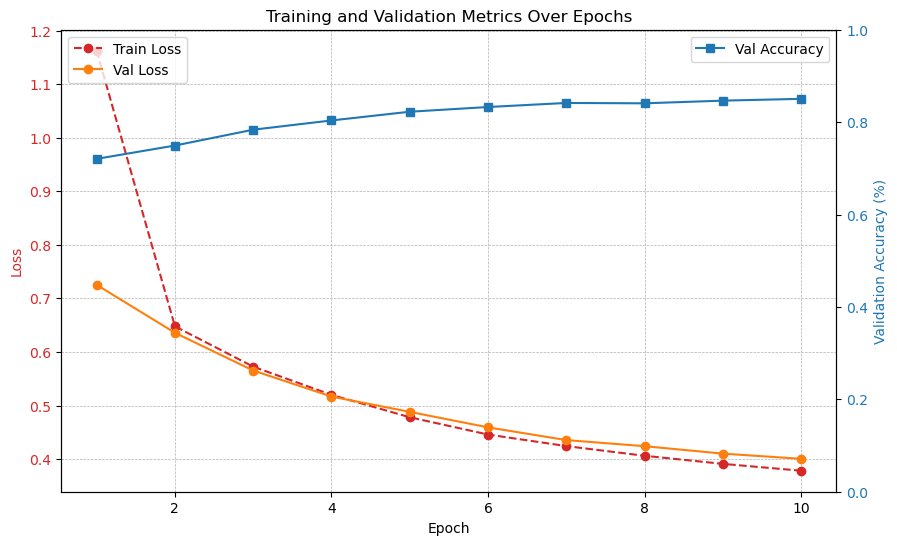

In [6]:
# Initialize model
model = LeNet()
# Train
trained_model, history = train_cnn(model, train_loader, val_loader, num_epochs=10)


# Large Kernel Size (10), regualr pool size

Starting training...

Epoch [1/10] - Train Loss: 1.3198, Val Loss: 0.9072, Val Acc: 64.61% ✓
Epoch [2/10] - Train Loss: 0.8019, Val Loss: 0.7489, Val Acc: 72.37% ✓
Epoch [3/10] - Train Loss: 0.6793, Val Loss: 0.6776, Val Acc: 74.47% ✓
Epoch [4/10] - Train Loss: 0.6189, Val Loss: 0.6225, Val Acc: 76.68% ✓
Epoch [5/10] - Train Loss: 0.5790, Val Loss: 0.6095, Val Acc: 76.73% ✓
Epoch [6/10] - Train Loss: 0.5514, Val Loss: 0.5748, Val Acc: 78.92% ✓
Epoch [7/10] - Train Loss: 0.5277, Val Loss: 0.5437, Val Acc: 79.41% ✓
Epoch [8/10] - Train Loss: 0.5068, Val Loss: 0.5452, Val Acc: 79.91% (no improvement 1/5)
Epoch [9/10] - Train Loss: 0.4913, Val Loss: 0.5211, Val Acc: 80.61% ✓
Epoch [10/10] - Train Loss: 0.4766, Val Loss: 0.5054, Val Acc: 80.98% ✓

Restored best model based on validation loss.

Training complete!
Best Validation Loss: 0.5054


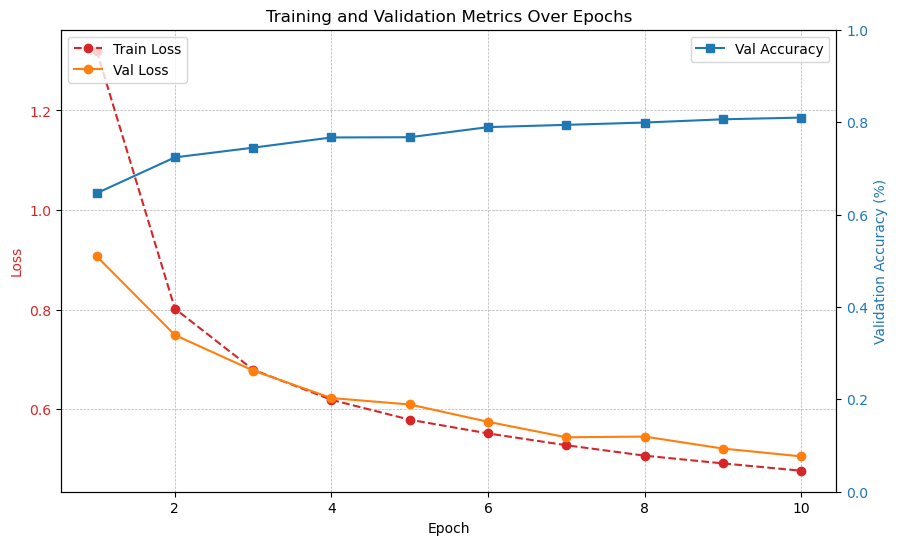

In [7]:
# Initialize model
model_2 = LeNet(kernel_1_size=10)
# Train
trained_model_2, history_2 = train_cnn(model_2, train_loader, val_loader, num_epochs=10)

# Regular kernel size, large pool size (4)

Starting training...

Epoch [1/10] - Train Loss: 1.3763, Val Loss: 0.9202, Val Acc: 65.33% ✓
Epoch [2/10] - Train Loss: 0.8463, Val Loss: 0.8149, Val Acc: 68.82% ✓
Epoch [3/10] - Train Loss: 0.7701, Val Loss: 0.7590, Val Acc: 71.04% ✓
Epoch [4/10] - Train Loss: 0.7171, Val Loss: 0.7088, Val Acc: 73.47% ✓
Epoch [5/10] - Train Loss: 0.6746, Val Loss: 0.6846, Val Acc: 74.15% ✓
Epoch [6/10] - Train Loss: 0.6466, Val Loss: 0.6560, Val Acc: 75.44% ✓
Epoch [7/10] - Train Loss: 0.6268, Val Loss: 0.6409, Val Acc: 76.00% ✓
Epoch [8/10] - Train Loss: 0.6069, Val Loss: 0.6236, Val Acc: 76.37% ✓
Epoch [9/10] - Train Loss: 0.5943, Val Loss: 0.6079, Val Acc: 77.13% ✓
Epoch [10/10] - Train Loss: 0.5774, Val Loss: 0.5976, Val Acc: 77.36% ✓

Restored best model based on validation loss.

Training complete!
Best Validation Loss: 0.5976


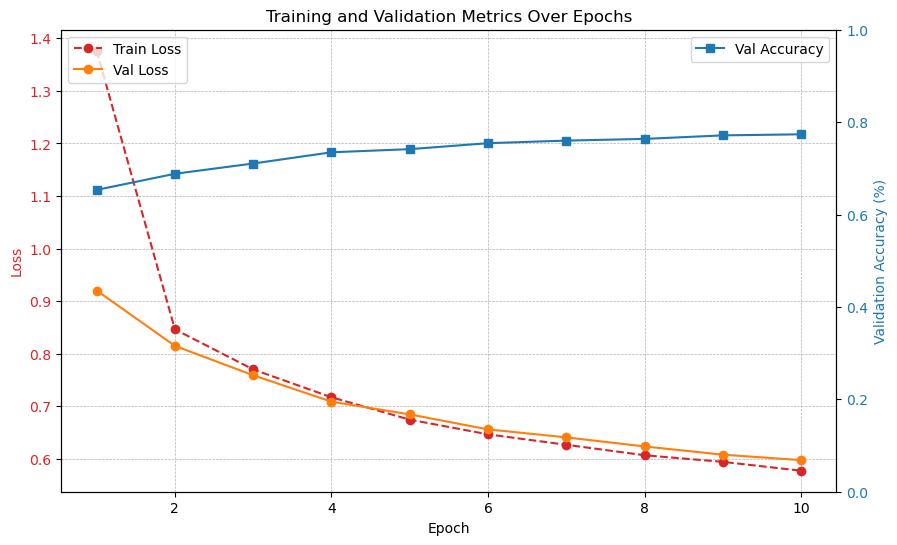

In [8]:
# Initialize model
model_3 = LeNet(pool_size=4)
# Train
trained_model_3, history_3 = train_cnn(model_3, train_loader, val_loader, num_epochs=10)

# Large kernel (10), large pool (4)

Starting training...

Epoch [1/10] - Train Loss: 1.4621, Val Loss: 1.0432, Val Acc: 59.40% ✓
Epoch [2/10] - Train Loss: 0.9265, Val Loss: 0.8673, Val Acc: 66.68% ✓
Epoch [3/10] - Train Loss: 0.8188, Val Loss: 0.7829, Val Acc: 70.75% ✓
Epoch [4/10] - Train Loss: 0.7391, Val Loss: 0.7327, Val Acc: 73.06% ✓
Epoch [5/10] - Train Loss: 0.6855, Val Loss: 0.6794, Val Acc: 74.98% ✓
Epoch [6/10] - Train Loss: 0.6527, Val Loss: 0.6663, Val Acc: 75.14% ✓
Epoch [7/10] - Train Loss: 0.6344, Val Loss: 0.6400, Val Acc: 76.19% ✓
Epoch [8/10] - Train Loss: 0.6168, Val Loss: 0.6321, Val Acc: 76.62% ✓
Epoch [9/10] - Train Loss: 0.6066, Val Loss: 0.6231, Val Acc: 76.70% ✓
Epoch [10/10] - Train Loss: 0.5953, Val Loss: 0.6077, Val Acc: 77.43% ✓

Restored best model based on validation loss.

Training complete!
Best Validation Loss: 0.6077


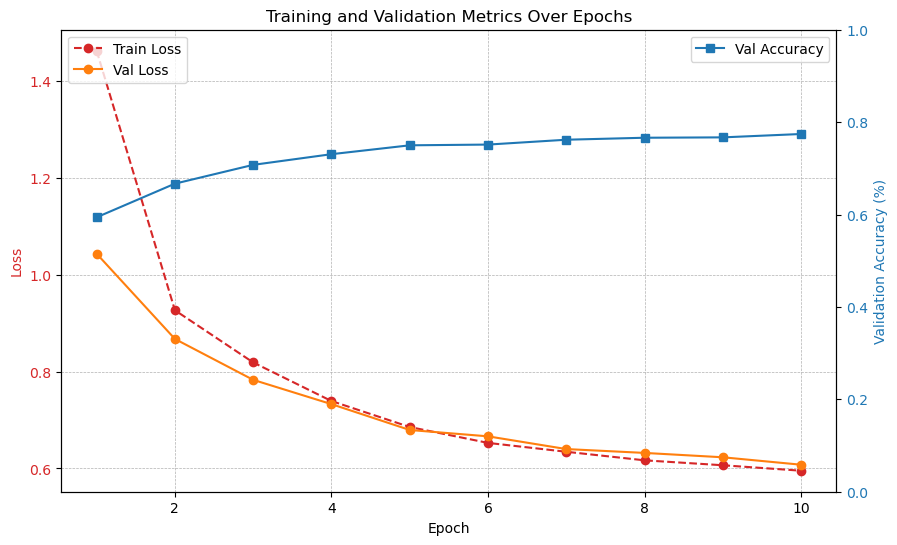

In [9]:
# Initialize model
model_4 = LeNet(kernel_1_size=10, pool_size=4)
# Train
trained_model_4, history_4 = train_cnn(model_4, train_loader, val_loader, num_epochs=10)

# Small kernel (2), regualr pool (2)

Starting training...

Epoch [1/10] - Train Loss: 1.3497, Val Loss: 0.7900, Val Acc: 70.95% ✓
Epoch [2/10] - Train Loss: 0.6949, Val Loss: 0.6546, Val Acc: 75.26% ✓
Epoch [3/10] - Train Loss: 0.6014, Val Loss: 0.5926, Val Acc: 77.35% ✓
Epoch [4/10] - Train Loss: 0.5505, Val Loss: 0.5593, Val Acc: 79.32% ✓
Epoch [5/10] - Train Loss: 0.5086, Val Loss: 0.5280, Val Acc: 80.08% ✓
Epoch [6/10] - Train Loss: 0.4732, Val Loss: 0.4974, Val Acc: 81.36% ✓
Epoch [7/10] - Train Loss: 0.4493, Val Loss: 0.4678, Val Acc: 82.86% ✓
Epoch [8/10] - Train Loss: 0.4305, Val Loss: 0.4567, Val Acc: 82.91% ✓
Epoch [9/10] - Train Loss: 0.4126, Val Loss: 0.4617, Val Acc: 82.29% (no improvement 1/5)
Epoch [10/10] - Train Loss: 0.4009, Val Loss: 0.4454, Val Acc: 83.36% ✓

Restored best model based on validation loss.

Training complete!
Best Validation Loss: 0.4454


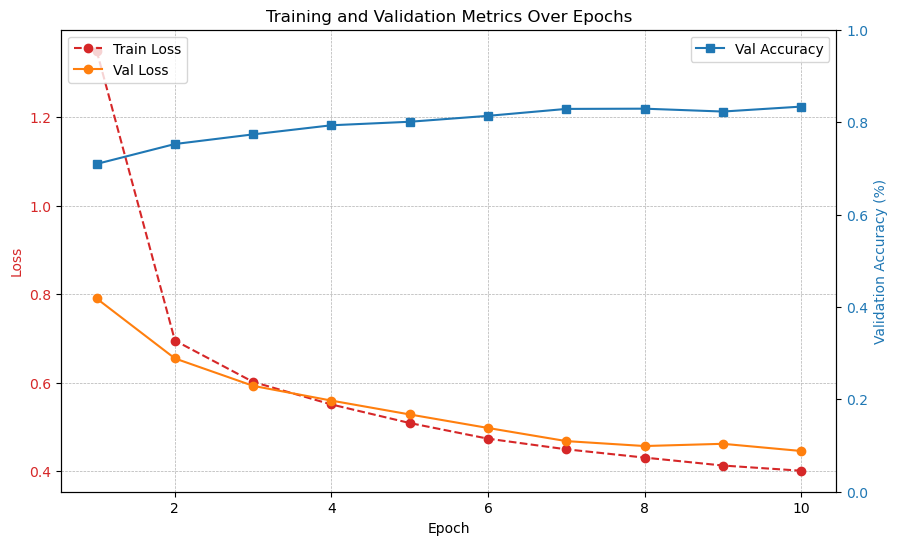

In [10]:
# Initialize model
model_5 = LeNet(kernel_1_size=2)
# Train
trained_model_5, history_5 = train_cnn(model_5, train_loader, val_loader, num_epochs=10)

# Short discussion 

From changing the kenel and pool size on several different models, it appears that as both the kernel and pool size increase (whether indivdualy or simultaneously) the accuracy of the model decreases. This implies that shrinking the image down faster will negitively affect the accuracy, while keeping the image larger (and therefore more information on the image) will positively affect accuracy. When decreasing the kernel size, I observed that the accuracy was better than increasing the kernel size, but was still slightly worse than the default size I set as 5. This implies that there is some happy medium between a small and large kernel size. 

The best accuracy I obtained was ~85%